# Neural Network with own Embedding

### Travail effectué
* NN avec 4 couches
* Sans fine tuning
* Avec le dataset train complet

### Conclusion
* Enorme Underfitting
* Le modèle a du mal à apprendre : revoir le traitement des données, tester CNN, tester fine tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report
from Fonctions_utils import f1_m, matrix_confusion

In [2]:
df_train = pd.read_csv("../../data_models/df_train_undersampling.csv")
df_val = pd.read_csv("../../data_models/df_val.csv")
df_test = pd.read_csv("../../data_models/df_test.csv")

In [16]:
sentences_train = df_train["text_clean"].values.astype(str)
sentences_val = df_val["text_clean"].values.astype(str)
sentences_test = df_test["text_clean"].values.astype(str)

y_train = df_train["Insult"].values
y_val = df_val["Insult"].values
y_test = df_test["Insult"].values

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_val = tokenizer.texts_to_sequences(sentences_val)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

7172

The indexing is ordered after the most common words in the text, which you can see by the word the having the index 1. It is important to note that the index 0 is reserved and is not assigned to any word. This zero index is used for padding, which I’ll introduce in a moment

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

In [19]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [20]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m,'accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           358600    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 359,121
Trainable params: 359,121
Non-trainable params: 0
_________________________________________________________________


In [21]:
es = EarlyStopping(monitor='val_f1_m', mode='min', patience=10)

history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    batch_size=10,
                    callbacks=[es])

Train on 1492 samples, validate on 1184 samples
Epoch 1/30
1492/1492 [==============================] - 2s 2ms/sample - loss: 0.6816 - f1_m: 0.6875 - accuracy: 0.6501 - val_loss: 0.6640 - val_f1_m: 0.5487 - val_accuracy: 0.7069
Epoch 2/30
1492/1492 [==============================] - 1s 823us/sample - loss: 0.6159 - f1_m: 0.7259 - accuracy: 0.7534 - val_loss: 0.6045 - val_f1_m: 0.5520 - val_accuracy: 0.6917
Epoch 3/30
1492/1492 [==============================] - 1s 742us/sample - loss: 0.4772 - f1_m: 0.8031 - accuracy: 0.8137 - val_loss: 0.4697 - val_f1_m: 0.5892 - val_accuracy: 0.7905
Epoch 4/30
1492/1492 [==============================] - 1s 704us/sample - loss: 0.3328 - f1_m: 0.8749 - accuracy: 0.8854 - val_loss: 0.4396 - val_f1_m: 0.6168 - val_accuracy: 0.7905
Epoch 5/30
1492/1492 [==============================] - 1s 701us/sample - loss: 0.2185 - f1_m: 0.9225 - accuracy: 0.9303 - val_loss: 0.3923 - val_f1_m: 0.6300 - val_accuracy: 0.8252
Epoch 6/30
1492/1492 [======================

## Performance

loss, accuracy_train = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_train))
loss, accuracy_val = model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy_val))
loss, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy:  {:.4f}".format(accuracy_test))

In [22]:
def plot_score_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    f1_m = history.history['f1_m']
    val_f1_m = history.history['val_f1_m']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, f1_m, 'b', label='Training f1 Score')
    plt.plot(x, val_f1_m, 'r', label='Validation f1 Score')
    plt.title('F1 score')
    plt.legend()
    
    plt.subplot(1, 3, 2)    
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()

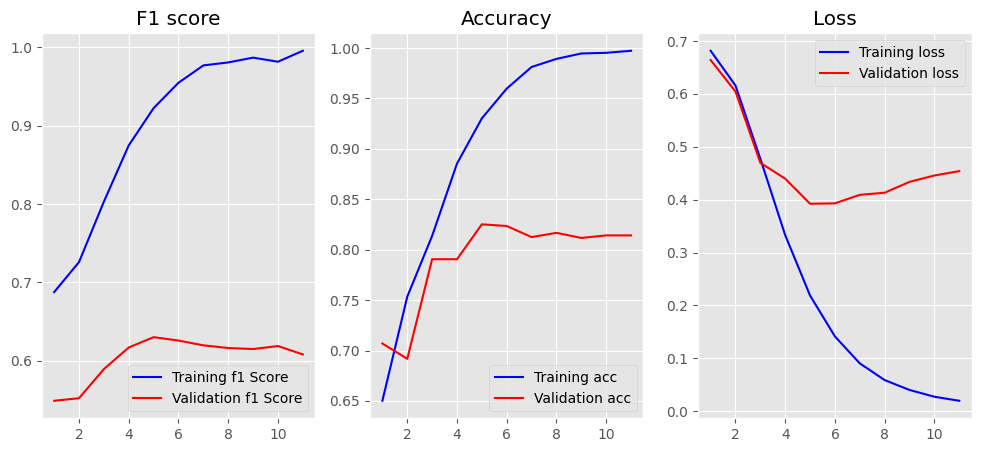

In [23]:
plot_score_model(history)

In [24]:
y_predict_test = model.predict(X_test)
y_predict_test2 = [round(item) for sublist in y_predict_test.tolist() for item in sublist]

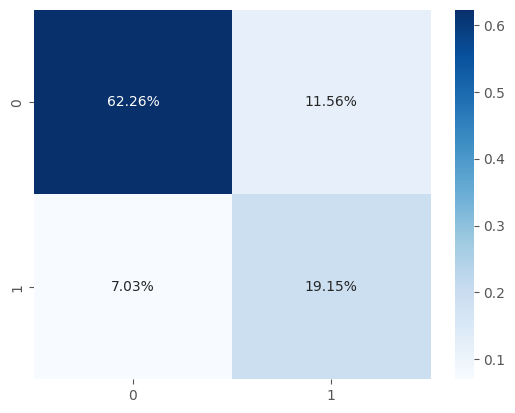

In [25]:
matrix_confusion(y_test, y_predict_test2)

In [26]:
target_names = ['Neutre', 'Insultant']
print(classification_report(y_test, y_predict_test2, target_names=target_names))

              precision    recall  f1-score   support

      Neutre       0.90      0.84      0.87      1954
   Insultant       0.62      0.73      0.67       693

    accuracy                           0.81      2647
   macro avg       0.76      0.79      0.77      2647
weighted avg       0.83      0.81      0.82      2647

